In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image

# Установка стилистики графиков
plt.style.use('ggplot')
plt.style.available

# Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cpu')

In [17]:
model = models.resnet18(pretrained=True)

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

/Users/damrorus/anaconda3/envs/cv_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/damrorus/anaconda3/envs/cv_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Определим пути к данным 
train_data_dir = 'dataset/train'
val_data_dir = 'dataset/valid'

# Определим трансформации
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(13),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),  # Добавим вертикальное отражение
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создадим датасеты
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_data_dir, transform=val_transforms)

# Создадим датагенераторы
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

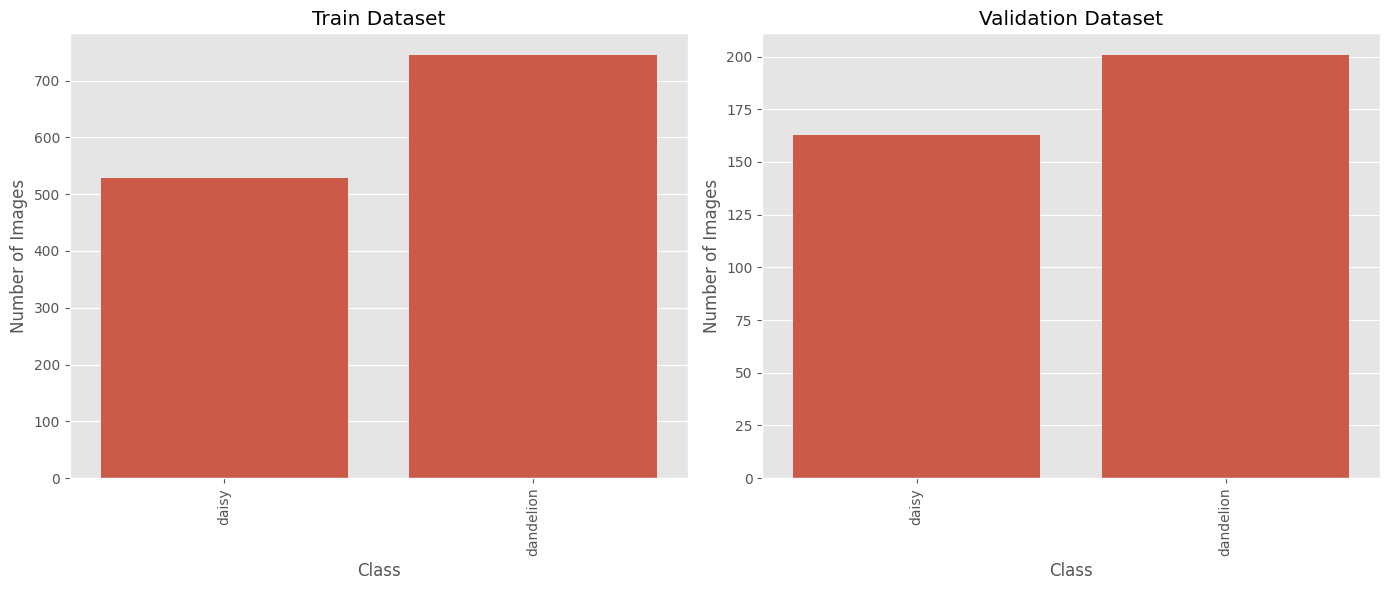

In [19]:
# train
train_class_counts = np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
    train_class_counts[label] += 1

# validation
val_class_counts = np.zeros(len(val_dataset.classes))
for _, label in val_dataset:
    val_class_counts[label] += 1

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot train
sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

# Barplot valid
sns.barplot(x=val_dataset.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.0947855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.448279

Images without normalization:


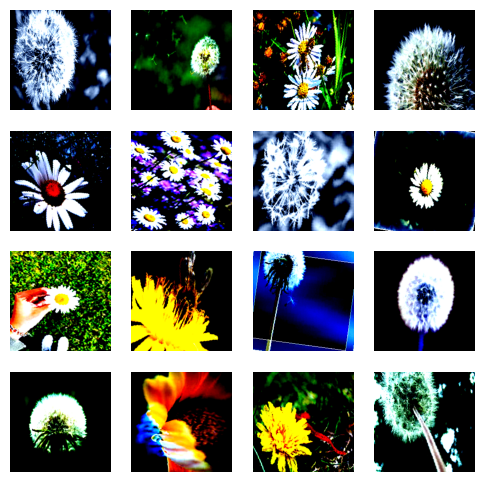

In [20]:
def show_images(images, denormalize=False):
    if denormalize:
        # Обратное преобразование для нормализации
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    else:
        images = images.numpy().transpose((0, 2, 3, 1))
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

# Получение первого батча из тренировочного загрузчика данных
images, _ = next(iter(train_loader))

# Отображение изображений с восстановлением цветов
print("Images without normalization:")
show_images(images, denormalize=False)

In [21]:
len(train_loader), len(val_loader)

(20, 6)

In [22]:
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
val_accuracy = correct / total
print(val_accuracy)

100%|██████████| 6/6 [00:10<00:00,  1.83s/it]

0.5467032967032966


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
   
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model!')
    
    torch.save(model.state_dict(), 'last_model.pth')
    print()

print('Training and validation complete!')

100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch [1/10], Train Loss: 0.2470, Train Accuracy: 0.8933, Val Loss: 0.5601, Val Accuracy: 0.9203
Saved best model!



100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch [2/10], Train Loss: 0.1181, Train Accuracy: 0.9506, Val Loss: 0.2995, Val Accuracy: 0.9148



100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch [3/10], Train Loss: 0.1025, Train Accuracy: 0.9639, Val Loss: 0.1076, Val Accuracy: 0.9533
Saved best model!



100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


Epoch [4/10], Train Loss: 0.0532, Train Accuracy: 0.9804, Val Loss: 0.1155, Val Accuracy: 0.9533



100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


Epoch [5/10], Train Loss: 0.0386, Train Accuracy: 0.9851, Val Loss: 0.1079, Val Accuracy: 0.9725
Saved best model!



100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Epoch [6/10], Train Loss: 0.0415, Train Accuracy: 0.9859, Val Loss: 0.4454, Val Accuracy: 0.8736



100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch [7/10], Train Loss: 0.0534, Train Accuracy: 0.9773, Val Loss: 0.1654, Val Accuracy: 0.9643



100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


Epoch [8/10], Train Loss: 0.0469, Train Accuracy: 0.9820, Val Loss: 0.1535, Val Accuracy: 0.9533



100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


Epoch [9/10], Train Loss: 0.0405, Train Accuracy: 0.9859, Val Loss: 0.1707, Val Accuracy: 0.9505



100%|██████████| 6/6 [00:12<00:00,  2.01s/it]

Epoch [10/10], Train Loss: 0.0319, Train Accuracy: 0.9867, Val Loss: 0.1300, Val Accuracy: 0.9505

Training and validation complete!


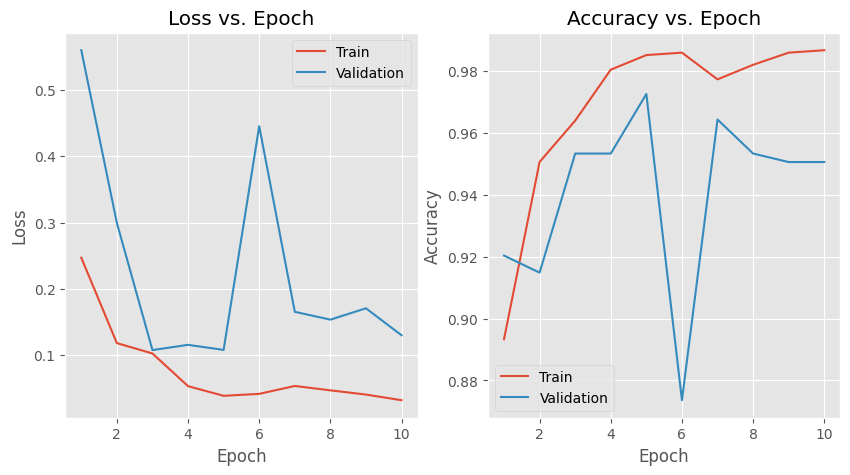

In [24]:
# Построим графики
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [25]:
# Получение метрик качества для текущих весов модели
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Вычисление взвешенной F1-меры для текущей модели
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

# Функция для построения графика матрицы ошибок
def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):  
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

/var/folders/3y/c2jgq3vs0rx4r_ycb6mq2r5r0000gn/T/ipykernel_47520/74104890.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt

Metrics for current model:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       163
           1       0.98      0.97      0.97       201

    accuracy                           0.97       364
   macro avg       0.97      0.97      0.97       364
weighted avg       0.97      0.97      0.97       364

Test Accuracy: 0.9725


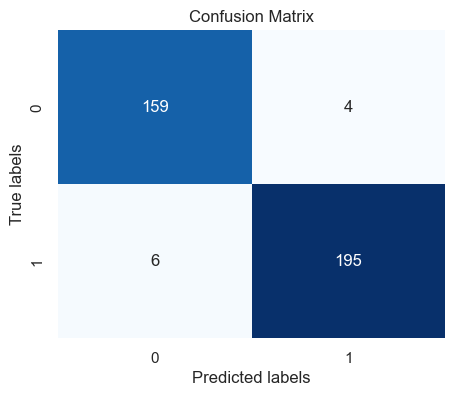

In [26]:
# Загрузка весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(2)))